In [1]:
import numpy as np

path_to_gaussian_result = '../bayes_implicit_solvent/continuous_parameter_experiments/freesolv_mh_jax_march28_gaussian_ll.npz'
path_to_student_t_result = '../bayes_implicit_solvent/continuous_parameter_experiments/freesolv_mh_jax_march28_student-t_ll.npz'

In [5]:
gaussian_result = np.load(path_to_gaussian_result)
list(gaussian_result.keys())

['traj', 'log_prob_traj', 'expt_means', 'expt_uncs', 'cids', 'elements']

In [7]:
train_cids = gaussian_result['cids']

Get the molecules and a function for computing predictions

In [4]:
import numpy as np
from bayes_implicit_solvent.molecule import Molecule
from simtk import unit


def sample_path_to_unitted_snapshots(path_to_npy_samples):
    xyz = np.load(path_to_npy_samples)
    traj = [snapshot * unit.nanometer for snapshot in xyz]
    return traj


from glob import glob
from pkg_resources import resource_filename

path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                           'vacuum_samples/vacuum_samples_*.npy')
paths_to_samples = glob(path_to_vacuum_samples)
#np.random.seed(0)
#np.random.shuffle(paths_to_samples)
#paths_to_samples = paths_to_samples[::2]

print('number of molecules being considered: {}'.format(len(paths_to_samples)))


def extract_cid_key(path):
    i = path.find('mobley_')
    j = path.find('.npy')
    return path[i:j]


cids = list(map(extract_cid_key, paths_to_samples))
print('first few CIDs', cids[:5])

mols = []

n_configuration_samples = 50

from bayes_implicit_solvent.freesolv import cid_to_smiles

from bayes_implicit_solvent.constants import beta
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)

for path in paths_to_samples:
    cid = extract_cid_key(path)
    smiles = cid_to_smiles[cid]
    vacuum_samples = sample_path_to_unitted_snapshots(path)
    thinning = int(len(vacuum_samples) / n_configuration_samples)
    mol = Molecule(smiles, vacuum_samples=vacuum_samples[::thinning])

    if (unreduce(mol.experimental_value) > -15) and (unreduce(mol.experimental_value) < 5):
        mols.append(mol)
    else:
        print('discarding {} ({}) because its free energy was outside of the range [-15, +5] kcal/mol'.format(smiles, cid))


import numpy as np
element_inds = []
all_elements = ['S', 'Cl', 'F', 'C', 'I', 'N', 'Br', 'H', 'P', 'O']
N = len(all_elements)
element_dict = dict(zip(all_elements, range(len(all_elements))))

initial_radius_dict = dict(H=0.12, C=0.17, N=0.155, O=0.15, F=0.15,
                   P=0.185, S=0.18, Cl=0.17, Br=0.15, I=0.15)
initial_scaling_factor_dict = dict(H=0.85, C=0.72, N=0.79, O=0.85, F=0.88,
                           P=0.86, S=0.96, Cl=0.80, Br=0.80, I=0.80)


for mol in mols:
    element_inds.append(np.array([element_dict[a.element.symbol] for a in list(mol.top.atoms())]))

from jax import jit, vmap
from bayes_implicit_solvent.gb_models.jax_gb_models import compute_OBC_energy_vectorized
from bayes_implicit_solvent.solvation_free_energy import kj_mol_to_kT, one_sided_exp

@jit
def predict_solvation_free_energy_jax(theta, distance_matrices, charges, element_ind_array):
    radii_, scaling_factors_ = theta[:N], theta[N:]

    radii = radii_[element_ind_array]
    scaling_factors = scaling_factors_[element_ind_array]

    @jit
    def compute_component(distance_matrix):
        return compute_OBC_energy_vectorized(distance_matrix, radii, scaling_factors, charges)

    W_F = vmap(compute_component)(distance_matrices)

    w_F = W_F * kj_mol_to_kT
    return one_sided_exp(w_F)

distance_matrices = [mol.distance_matrices for mol in mols]
charges = [mol.charges for mol in mols]


expt_means = unreduce(np.array([mol.experimental_value for mol in mols]))
expt_uncs = unreduce(np.array([mol.experimental_uncertainty for mol in mols]))

number of molecules being considered: 642
first few CIDs ['mobley_3210206', 'mobley_3589456', 'mobley_1107178', 'mobley_5200358', 'mobley_1781152']


/Users/joshuafass/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:167: UserWarning: No GPU found, falling back to CPU.
  warnings.warn('No GPU found, falling back to CPU.')


discarding c1c(c(=O)[nH]c(=O)[nH]1)C(F)(F)F (mobley_7794077) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(c(=O)[nH]c(=O)[nH]1)F (mobley_337666) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(=O)[nH]c(=O)[nH]c1Cl (mobley_4338603) because its free energy was outside of the range [-15, +5] kcal/mol
discarding C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O (mobley_4587267) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1ccc(cc1)n2c(=O)c(c(cn2)N)Cl (mobley_2523689) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(c(=O)[nH]c(=O)[nH]1)Cl (mobley_9557440) because its free energy was outside of the range [-15, +5] kcal/mol
discarding c1c(c(=O)[nH]c(=O)[nH]1)I (mobley_2727678) because its free energy was outside of the range [-15, +5] kcal/mol
discarding C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O (mobley_9534740) because its free energy was outside of the ra

# Split properly into train and test...

In [17]:
gaussian_traj = gaussian_result['traj']
theta = gaussian_traj[0]

In [11]:
predict_solvation_free_energy_jax(theta, distance_matrices[0], charges[0], element_inds[0])

array(-7.083345, dtype=float32)

In [14]:
def get_predictions(theta):
    return np.array([predict_solvation_free_energy_jax(theta, distance_matrices[i], charges[i], element_inds[i]) for i in range(len(charges))])

In [16]:
predictions = get_predictions(theta)

In [18]:
from tqdm import tqdm

In [19]:
thinning = 100
gaussian_prediction_traj = np.array([get_predictions(theta) for theta in tqdm(gaussian_traj[::thinning])])

100%|██████████| 1001/1001 [06:20<00:00,  1.79it/s]


In [20]:
student_t_result = np.load(path_to_student_t_result)
student_t_traj = student_t_result['traj']
student_t_prediction_traj = np.array([get_predictions(theta) for theta in tqdm(student_t_traj[::thinning])])

100%|██████████| 1001/1001 [07:54<00:00,  2.45it/s]


In [32]:
# unreduce!

reduced_student_t_prediction_traj = np.array(student_t_prediction_traj)
reduced_gaussian_prediction_traj = np.array(gaussian_prediction_traj)

In [33]:
student_t_prediction_traj = unreduce(reduced_student_t_prediction_traj)
gaussian_prediction_traj = unreduce(gaussian_prediction_traj)

In [34]:
def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

In [35]:
print(np.max(student_t_prediction_traj[10:].std(0)), np.min(student_t_prediction_traj[10:].std(0)))

print(np.max(gaussian_prediction_traj[10:].std(0)), np.min(gaussian_prediction_traj[10:].std(0)))

5.218369 0.040243644
2.0742083 0.036575284


In [49]:
rmse(student_t_prediction_traj[-1], expt_means), rmse(gaussian_prediction_traj[-1], expt_means)

(1.6975416008139375, 2.0685566892980245)

2.0685566892980245

In [39]:
mol = mols[0]

In [42]:
from bayes_implicit_solvent.freesolv import smiles_to_cid
smiles_to_cid[mol.smiles]

'mobley_3210206'

In [44]:
cids[0]

'mobley_3210206'

In [46]:
len(train_cids)

321

In [47]:
train_inds = []
test_inds = []
for i in range(len(mols)):
    if smiles_to_cid[mols[i].smiles] in train_cids:
        train_inds.append(i)
    else:
        test_inds.append(i)

In [48]:
train_inds = np.array(train_inds)
test_inds = np.array(test_inds)

In [239]:
test_inds

array([  0,   4,   7,   9,  11,  12,  14,  15,  19,  25,  26,  27,  29,
        30,  31,  34,  35,  38,  40,  42,  45,  47,  50,  53,  55,  58,
        59,  60,  61,  63,  65,  67,  69,  71,  72,  74,  75,  76,  77,
        78,  80,  81,  86,  87,  88,  89,  90,  91,  93,  95,  96,  98,
        99, 102, 103, 106, 108, 112, 113, 114, 116, 124, 125, 127, 128,
       130, 133, 134, 135, 136, 137, 140, 141, 147, 148, 149, 150, 153,
       155, 158, 160, 161, 165, 167, 168, 169, 170, 171, 174, 178, 179,
       180, 181, 182, 185, 186, 189, 191, 192, 193, 194, 197, 198, 202,
       203, 206, 207, 209, 210, 211, 212, 213, 217, 218, 219, 220, 221,
       222, 224, 225, 228, 231, 234, 235, 236, 237, 241, 242, 247, 248,
       249, 250, 251, 252, 253, 256, 257, 258, 259, 260, 261, 265, 268,
       269, 272, 276, 280, 281, 282, 283, 284, 285, 286, 287, 288, 293,
       294, 297, 300, 309, 310, 313, 314, 315, 316, 317, 318, 323, 325,
       327, 330, 331, 332, 334, 335, 338, 339, 343, 344, 348, 34

In [50]:
rmse(student_t_prediction_traj[-1][train_inds], expt_means[train_inds]), rmse(gaussian_prediction_traj[-1][train_inds], expt_means[train_inds])

(1.637675008156739, 1.978476253481645)

In [52]:
rmse(student_t_prediction_traj[-1][test_inds], expt_means[test_inds]), rmse(gaussian_prediction_traj[-1][test_inds], expt_means[test_inds])



(1.7551876480068598, 2.1546070644033675)

In [58]:
def train_rmse(preds):
    return rmse(preds[train_inds], expt_means[train_inds])
def test_rmse(preds):
    return rmse(preds[test_inds], expt_means[test_inds])

student_t_train_rmse_traj = np.array(list(map(train_rmse, student_t_prediction_traj)))
student_t_test_rmse_traj = np.array(list(map(test_rmse, student_t_prediction_traj)))

gaussian_train_rmse_traj = np.array(list(map(train_rmse, gaussian_prediction_traj)))
gaussian_test_rmse_traj = np.array(list(map(test_rmse, gaussian_prediction_traj)))

In [235]:
x = np.arange(len(student_t_prediction_traj)) * thinning

In [260]:
train_color = 'lightblue'
test_color = 'green'
train_style = '--'
test_style = '-'

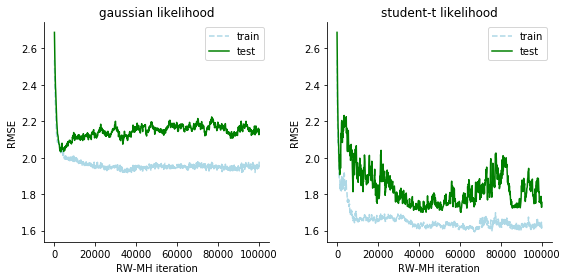

In [261]:
import matplotlib.pyplot as plt
%matplotlib inline

from bayes_implicit_solvent.utils import remove_top_right_spines

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,2)
remove_top_right_spines(ax)
plt.plot(x, student_t_train_rmse_traj, label='train', c=train_color, linestyle=train_style)
plt.plot(x, student_t_test_rmse_traj, label='test', c=test_color, linestyle=test_style)
plt.legend()
plt.title('student-t likelihood')
plt.ylabel('RMSE')
plt.xlabel('RW-MH iteration')

ax = plt.subplot(1,2,1, sharey=ax)
remove_top_right_spines(ax)
plt.plot(x, gaussian_train_rmse_traj, label='train', c=train_color, linestyle=train_style)
plt.plot(x, gaussian_test_rmse_traj, label='test', c=test_color, linestyle=test_style)
plt.legend()
plt.title('gaussian likelihood')
plt.ylabel('RMSE')
plt.xlabel('RW-MH iteration')
plt.tight_layout()

plt.savefig('RW-MH-RMSE.png', dpi=300, bbox_inches='tight')

In [73]:
# okay cool! now let's try to estimate the mixing time?

# maybe later...

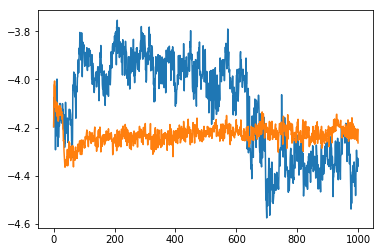

In [89]:
plt.plot(student_t_prediction_traj[:,0])
plt.plot(gaussian_prediction_traj[:,0])

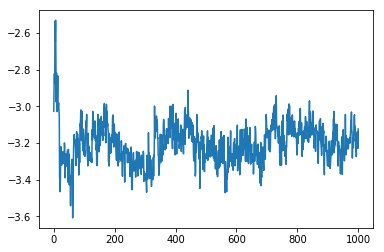

In [78]:
plt.plot(student_t_prediction_traj[:,1])

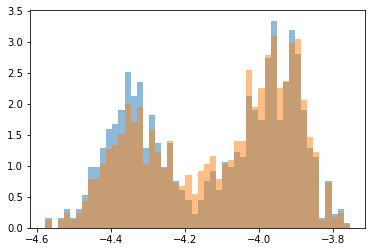

In [84]:
plt.hist(student_t_prediction_traj[200:,0], bins=50, density=True, alpha=0.5);
plt.hist(student_t_prediction_traj[:,0], bins=50, density=True, alpha=0.5);

In [87]:
i = test_inds[0]
i

0

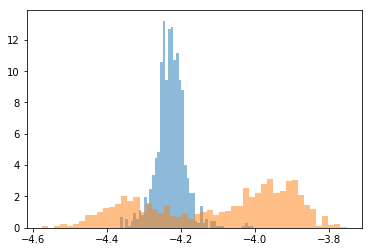

In [90]:
plt.hist(gaussian_prediction_traj[:,i], bins=50, density=True, alpha=0.5);
plt.hist(student_t_prediction_traj[:,i], bins=50, density=True, alpha=0.5);

In [91]:
from scipy.stats import norm

'c1ccc(cc1)S'

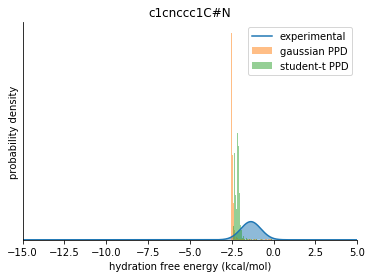

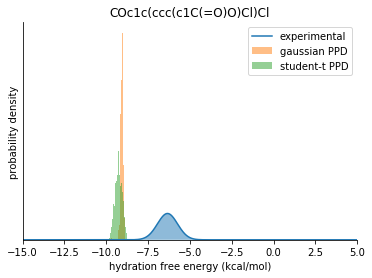

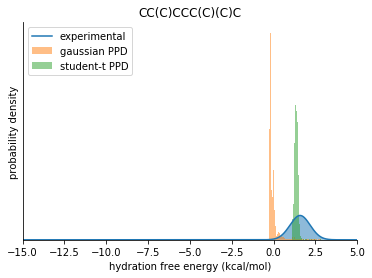

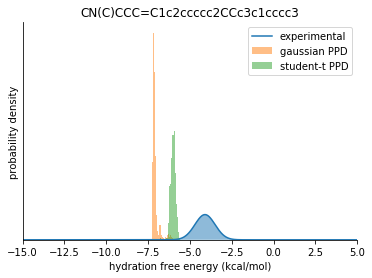

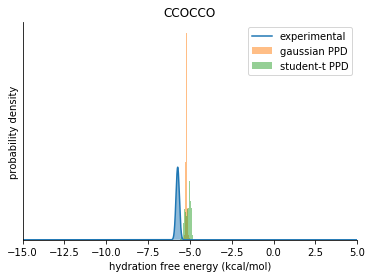

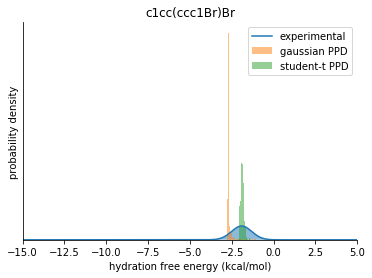

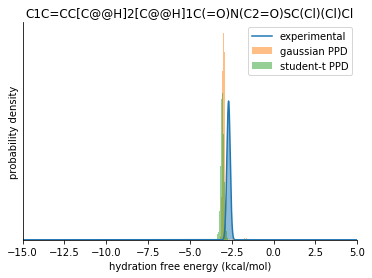

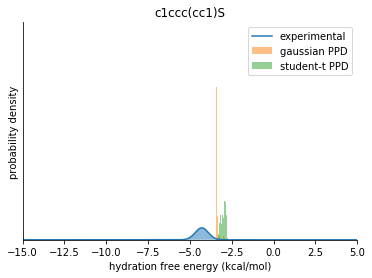

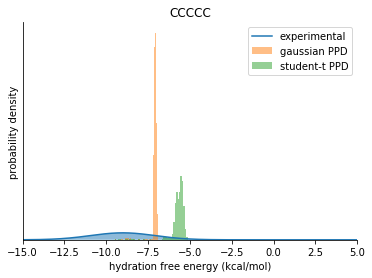

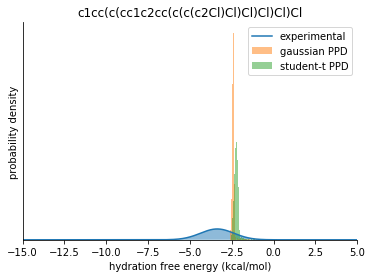

In [266]:


for _ in range(10):
    min_x, max_x = = -15,5
    i = np.random.randint(len(test_inds))
    plt.figure()
    ax = plt.subplot(1,1,1)
    remove_top_right_spines(ax)
    
    plt.title(mols[test_inds[i]].smiles)
    x_ = np.linspace(-15,5,10000)
    y_ = norm.pdf(x_, loc=expt_means[i], scale=expt_uncs[i])
    
    
    
    plt.plot(x_, y_, label='experimental')
    plt.fill_between(x_, y_, alpha=0.5)

    plt.hist(gaussian_prediction_traj[:,i], bins=50, density=True, alpha=0.5, label='gaussian PPD');
    plt.hist(student_t_prediction_traj[:,i], bins=50, density=True, alpha=0.5, label='student-t PPD');

    plt.xlim(-15,5)
    plt.legend()
    plt.xlabel('hydration free energy (kcal/mol)')
    plt.ylabel('probability density')
    plt.yticks([])

# Create a function that makes plots like these, and then make all of them, including a picture of the molecule!

# Then sort them from best to worst?

# Oh, compare also with the statistical uncertainty only!

# Summarize into some reliability curves

In [115]:
def expt_unc_contained(preds, i, desired_coverage=0.95):
    alpha = 100 * ((1 - desired_coverage) / 2)
    upper, lower = norm.cdf(np.percentile(preds, q=[100 - alpha, alpha]), loc=expt_means[i], scale=expt_uncs[i])
    return upper - lower

In [102]:
preds = student_t_prediction_traj[:,i]

In [124]:
desired_coverages = np.linspace(0,1)
actual_coverages = np.vstack([np.array([expt_unc_contained(student_t_prediction_traj[:,i], i, desired_coverage=p) for i in range(len(mols))]) for p in desired_coverages])

In [125]:
actual_coverages.shape

(50, 631)

(0, 1)

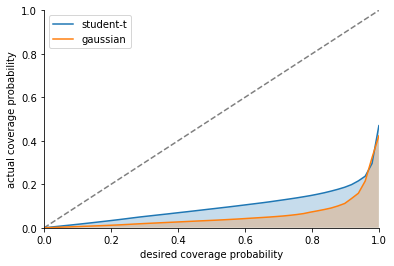

In [140]:
ax = plt.subplot(1,1,1)
remove_top_right_spines(ax)
plt.plot(desired_coverages, desired_coverages, c='grey', linestyle='--')

plt.plot(desired_coverages, np.mean(actual_coverages, 1), label='student-t')
plt.fill_between(desired_coverages, np.mean(actual_coverages, 1), alpha=0.25)

plt.plot(desired_coverages, np.mean(actual_coverages_gaussian, 1), label='gaussian')
plt.fill_between(desired_coverages, np.mean(actual_coverages_gaussian, 1), alpha=0.25)

plt.legend()
plt.xlabel('desired coverage probability')
plt.ylabel('actual coverage probability')
plt.xlim(0,1)
plt.ylim(0,1)



In [240]:
np.trapz(np.mean(actual_coverages_gaussian, 1), desired_coverages)

0.05395923345612556

In [134]:
actual_coverages_gaussian = np.vstack([np.array([expt_unc_contained(gaussian_prediction_traj[:,i], i, desired_coverage=p) for i in range(len(mols))]) for p in desired_coverages])

# what's a better way to show this...
A limitation is that this plot isn't sensitive to being over-confident in the tails. If your MCMC predictive is way out in the middle of nowhere, this doesn't distinguish much being super-confident in the middle of nowhere vs. being unconfident...

In [163]:
actual_coverages.shape

(50, 631)

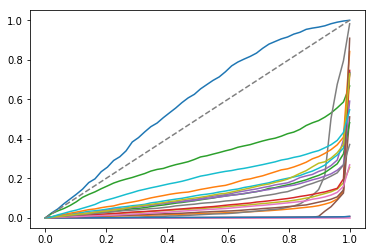

In [172]:
for i in np.random.randint(0,len(mols),20):
    plt.plot(desired_coverages, actual_coverages[:,i])
plt.plot(desired_coverages, desired_coverages, c='grey', linestyle='--')

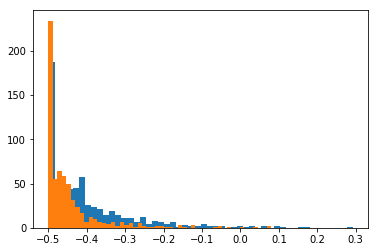

In [177]:
plt.hist([np.trapz(actual_coverages[:,i] - desired_coverages, desired_coverages) for i in range(len(mols))], bins=50);
plt.hist([np.trapz(actual_coverages_gaussian[:,i] - desired_coverages, desired_coverages) for i in range(len(mols))], bins=50);

In [136]:
np.mean([expt_unc_contained(gaussian_prediction_traj[:,i], i, desired_coverage=0.95) for i in range(len(mols))]), np.mean([expt_unc_contained(student_t_prediction_traj[:,i], i, desired_coverage=0.95) for i in range(len(mols))])

(0.18393854741252488, 0.22653345342750497)

In [ ]:
# what if I just scale up the intervals?

(array([492.,  91.,  24.,   8.,   2.,   6.,   4.,   2.,   1.,   1.]),
 array([0.        , 0.00233037, 0.00466073, 0.0069911 , 0.00932147,
        0.01165184, 0.0139822 , 0.01631257, 0.01864294, 0.0209733 ,
        0.02330367]),
 <a list of 10 Patch objects>)

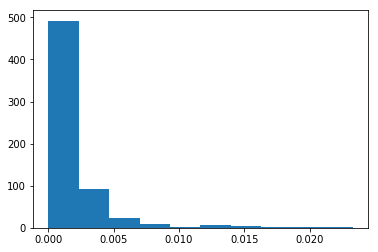

In [123]:
plt.hist(actual_coverages)
plt.

In [104]:
alphas = 

array([-3.8598671 , -4.42554903])

In [149]:
np.sum(norm.logpdf(0.5 * np.ones(10)))

-10.439385332046726

In [152]:
np.mean(theta[:int(len(theta)/2)]), np.mean(theta[int(len(theta)/2):])

(0.15799999999999997, 0.8310000000000001)

In [156]:
student_t_result['log_prob_traj'][15000]

-1130.3255050990656

In [162]:
np.max(student_t_result['log_prob_traj'])

-1090.8189462230137

In [201]:
student_t_result['log_prob_traj'][-1]

-1095.6240119936404

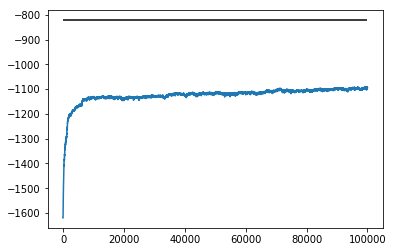

In [248]:
plt.plot(student_t_result['log_prob_traj'])
plt.hlines(-822,0,len(student_t_result['log_prob_traj']))

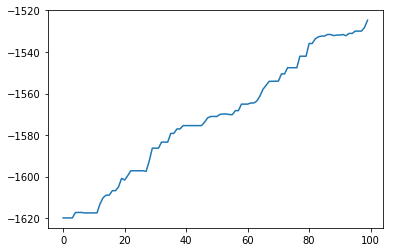

In [249]:
plt.plot(student_t_result['log_prob_traj'][:100])

In [258]:
np.argmax(student_t_result['log_prob_traj'] > -1303)/26

37.23076923076923

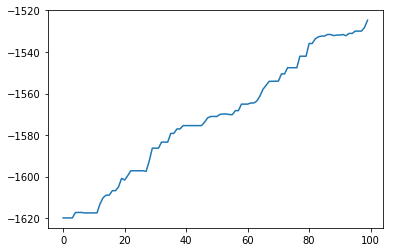

In [251]:
plt.plot(student_t_result['log_prob_traj'][:100])

In [229]:
-822 - np.max(student_t_result['log_prob_traj'])

268.81894622301365

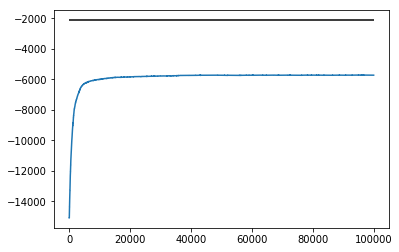

In [232]:
plt.plot(gaussian_result['log_prob_traj'])
plt.hlines(-2136,0,len(gaussian_result['log_prob_traj']))

In [241]:
min(gaussian_result['log_prob_traj'])

-15085.549845319523

In [233]:
(-2136 - max(gaussian_result['log_prob_traj']))

3587.724160741098

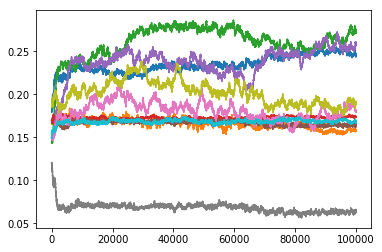

In [159]:
traj = student_t_result['traj']
N = int(len(traj[0]) / 2)
plt.plot(traj[:,:N])

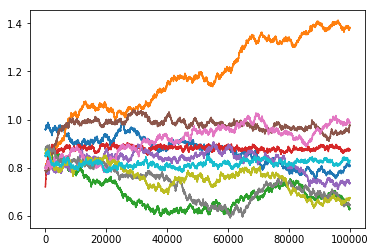

In [160]:
plt.plot(traj[:,N:])

In [ ]:
# can I already compare the marginal likelihood of the student-t vs. gaussian model?

In [181]:
from bayes_implicit_solvent.typers import AtomSpecificationProposal

np.random.seed(0)

from bayes_implicit_solvent.gb_models.obc2_parameters import mbondi_model

initial_tree = mbondi_model
if '[#14]' in initial_tree.nodes:
    initial_tree.remove_node('[#14]') # otherwise everything is -inf, because this type will be empty
initial_tree.proposal_sigmas['radius'] = 1e-2 * unit.nanometer
initial_tree.proposal_sigmas['scale_factor'] = 1e-2

# add one more parameter per element appearing in FreeSolv but not specified in obc2 parameter set to initial tree
for i in [17, 35, 53]:
    smirks = '[#{}]'.format(i)
    initial_tree.add_child(smirks, '*')
    initial_tree.un_delete_able_types.add(smirks)

specifiers = ['X1', 'X2', 'X3', 'X4', 'a', 'A', '-1', '+0', '+1', '+2']
atom_specification_proposal = AtomSpecificationProposal(atomic_specifiers=specifiers)
smirks_elaboration_proposal = atom_specification_proposal

atomic_specifiers (&'d into atom definitions)
	 ['X1', 'X2', 'X3', 'X4', 'a', 'A', '-1', '+0', '+1', '+2']


In [208]:
np.array([np.random.randn(np.random.randint(2,5)) for _ in range(10)])

array([array([-0.2008515 ,  0.38411077]),
       array([ 1.74443591, -1.85753223, -0.61197726,  0.59068814]),
       array([0.07121934, 1.2618769 ]), array([-1.85070899,  0.21670312]),
       array([ 0.0458843 , -0.74497041]),
       array([ 0.02768013, -1.02972439, -0.95919465, -1.19104703]),
       array([-1.39386084, -0.35447975, -1.02327899]),
       array([ 0.13538432, -0.44623967,  0.65615742]),
       array([ 0.08564227, -0.80259632,  0.26916359]),
       array([ 1.06473203,  0.31682597,  1.2989705 , -0.3437853 ])],
      dtype=object)

In [206]:
np.array([initial_tree, initial_tree])

array([*          (r = 1.50 Å, s = 0.80)
|-[#1]     (r = 1.20 Å, s = 0.85)
|-[#6]     (r = 1.70 Å, s = 0.72)
|-[#7]     (r = 1.55 Å, s = 0.79)
|-[#8]     (r = 1.50 Å, s = 0.85)
|-[#9]     (r = 1.50 Å, s = 0.88)
|-[#15]    (r = 1.85 Å, s = 0.86)
|-[#16]    (r = 1.80 Å, s = 0.96)
|-[#17]    (r = 1.50 Å, s = 0.80)
|-[#35]    (r = 1.50 Å, s = 0.80)
|-[#53]    (r = 1.50 Å, s = 0.80),
       *          (r = 1.50 Å, s = 0.80)
|-[#1]     (r = 1.20 Å, s = 0.85)
|-[#6]     (r = 1.70 Å, s = 0.72)
|-[#7]     (r = 1.55 Å, s = 0.79)
|-[#8]     (r = 1.50 Å, s = 0.85)
|-[#9]     (r = 1.50 Å, s = 0.88)
|-[#15]    (r = 1.85 Å, s = 0.86)
|-[#16]    (r = 1.80 Å, s = 0.96)
|-[#17]    (r = 1.50 Å, s = 0.80)
|-[#35]    (r = 1.50 Å, s = 0.80)
|-[#53]    (r = 1.50 Å, s = 0.80)], dtype=object)

In [186]:
smirks_elaboration_proposal(initial_tree.sample_decorate_able_node_uniformly_at_random())

{'proposal': '[#8&+0]', 'log_prob_forward_over_reverse': -2.302585092994046}

In [198]:
initial_tree.sample_create_delete_proposal(smirks_elaboration_proposal)

{'proposal': *              (r = 1.50 Å, s = 0.80)
 |-[#1]         (r = 1.20 Å, s = 0.85)
 |-[#6]         (r = 1.70 Å, s = 0.72)
 |-[#7]         (r = 1.55 Å, s = 0.79)
 |-[#8]         (r = 1.50 Å, s = 0.85)
 |-[#9]         (r = 1.50 Å, s = 0.88)
   |-[#9&X4]    (r = 1.43 Å, s = 0.85)
 |-[#15]        (r = 1.85 Å, s = 0.86)
 |-[#16]        (r = 1.80 Å, s = 0.96)
 |-[#17]        (r = 1.50 Å, s = 0.80)
 |-[#35]        (r = 1.50 Å, s = 0.80)
 |-[#53]        (r = 1.50 Å, s = 0.80),
 'log_prob_forward_over_reverse': -2.2875505121322117}

In [209]:
theta = student_t_traj[-1]

In [210]:
radii, scales = theta[:N], theta[N:]

In [211]:
radii

array([0.24621566, 0.15795924, 0.27500468, 0.17384848, 0.25868332,
       0.16261159, 0.17926987, 0.06597002, 0.18953871, 0.16663971])

In [215]:
all_elements = ['S', 'Cl', 'F', 'C', 'I', 'N', 'Br', 'H', 'P', 'O']

In [214]:
element_to_num_dict = {
    'S': 16,
    'Cl': 17,
    'F': 9,
    'C': 6,
    'I': 53,
    'N': 7,
    'Br': 35,
    'H': 1,
    'P': 15,
    'O': 8,
}

In [217]:
initial_radii_dict = {}
initial_scale_factor_dict = {}
for i in range(len(all_elements)):
    e = all_elements[i]
    n = element_to_num_dict[e]
    s = '[#{}]'.format(n)
    initial_radii_dict[s] = radii[i]
    initial_scale_factor_dict[s] = scales[i]
initial_radii_dict

{'[#16]': 0.24621565686059527,
 '[#17]': 0.15795923569608972,
 '[#9]': 0.27500468157621677,
 '[#6]': 0.1738484824704355,
 '[#53]': 0.25868331770794,
 '[#7]': 0.16261158548916488,
 '[#35]': 0.1792698694454788,
 '[#1]': 0.06597002277367196,
 '[#15]': 0.18953871099991065,
 '[#8]': 0.1666397113462544}

In [218]:
initial_scale_factor_dict

{'[#16]': 0.8085769087184602,
 '[#17]': 1.3791871302846694,
 '[#9]': 0.6320219796553284,
 '[#6]': 0.8753321883965008,
 '[#53]': 0.7366983185149338,
 '[#7]': 0.9768357275040189,
 '[#35]': 0.9873510702770019,
 '[#1]': 0.6464220642731573,
 '[#15]': 0.6735593070974721,
 '[#8]': 0.8309625595094741}

In [213]:
element_dict

{'S': 0,
 'Cl': 1,
 'F': 2,
 'C': 3,
 'I': 4,
 'N': 5,
 'Br': 6,
 'H': 7,
 'P': 8,
 'O': 9}

In [220]:
np.max(result['log_prob_traj'])

-5723.724160741098

# Move some of these figure-generating scripts from notebook into package